Package Import

In [ ]:
import sys
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
import pickle
print(tf.__version__)
#sys.path.append('./Extralib/das')

cwd = os.getcwd()
pardir = os.path.abspath(os.path.join(cwd, "Extralib"))
modeldir = os.path.abspath(os.path.join(pardir, "models"))

if pardir not in sys.path:
    sys.path.append(pardir)
from jDAS import JDAS
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler

def load_pickle_file(filename):
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except EOFError:
        print(f"Error: File {filename} is empty or corrupted.")
        return None

Retraining Results Plotting:
The following would be the plotting of the training loss and validaion loss.
To see all the updates of the history, just load the corresponding model summary of the data from the file "loss"

2.15.0


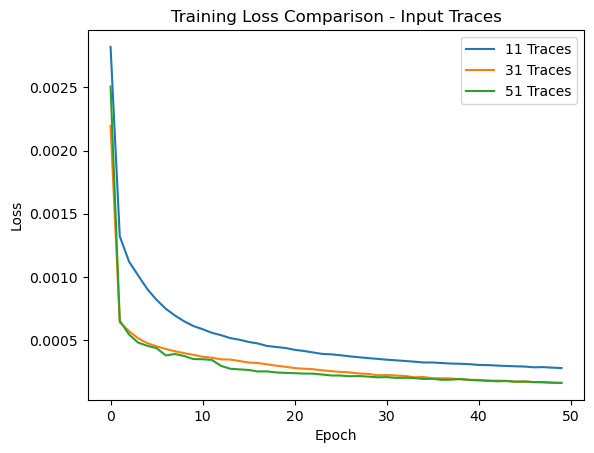

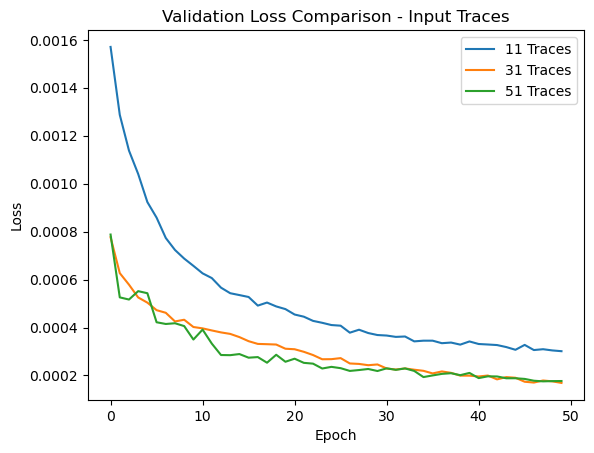

In [7]:
# Load histories
history1 = load_pickle_file('./loss/InputTraces/11_MinMax.pkl')
history2 = load_pickle_file('./loss/InputTraces/31_MinMax.pkl')
history3 = load_pickle_file('./loss/InputTraces/51_MinMax.pkl')


# Check the structure of loaded histories to ensure they are dictionaries
#print(history1.keys())
##print(history2.keys())
#print(history3.keys())
# Plot training loss for each model
plt.figure()
plt.plot(history1['loss'])
plt.plot(history2['loss'])
plt.plot(history3['loss'])
plt.title('Training Loss Comparison - Input Traces')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend([ '11 Traces', '31 Traces', '51 Traces'])
plt.show()

# Plot validation loss for each model
plt.figure()
plt.plot(history1['val_loss'])
plt.plot(history2['val_loss'])
plt.plot(history3['val_loss'])
plt.title('Validation Loss Comparison - Input Traces')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend([ '11 Traces', '31 Traces', '51 Traces'])
#plt.legend(['1 Mask', '2 Masks', '3 Masks'])
plt.show()




The following would be the results plotting for the Raw Data, Noise Data Added, Denoised Results with the P-wave SNR and S-wave SNR, and the absolute amplitude of the Denoised Results

In [9]:
#Bandpass Filtering Function
# Define the bandpass filter parameters
from scipy.signal import butter, filtfilt
fs = 2000  # Sampling frequency of your DAS data
lowcut = 1  # Low cutoff frequency (in Hz)
highcut = 250  # High cutoff frequency (in Hz)
order = 4  # Filter order

# Function to apply bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

(1029, 4096)


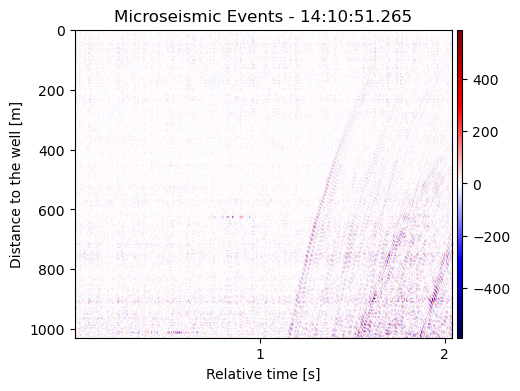

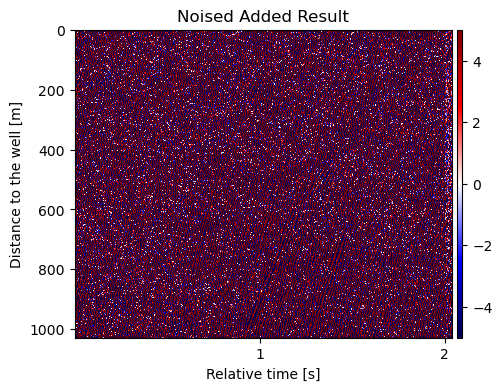

1.9151164595881316
Processing 1 / 3
33/33 [==============================] - 6s 170ms/step
Processing 2 / 3
33/33 [==============================] - 5s 139ms/step
Processing 3 / 3
33/33 [==============================] - 5s 138ms/step
Raw Relative SNR: (P-wave) 9.776032213892158
Raw Relative SNR: (S-wave) 16.501460261925
White Noise Added Relative SNR: (P-wave): 0.03724601365682501
White Noise Added Relative SNR: (S-wave) 0.06286943422709079
Denoised Relative SNR: (P-wave): 7.0925700415543504
Denoised Relative SNR: (S-wave) 4.733271062644847


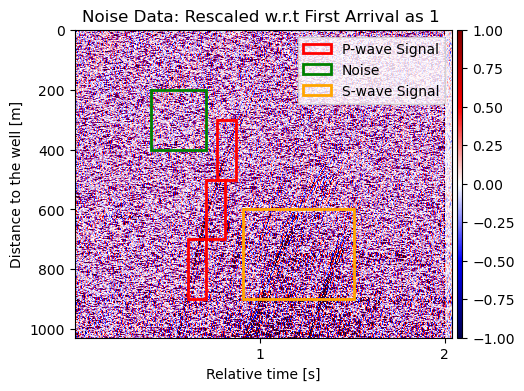

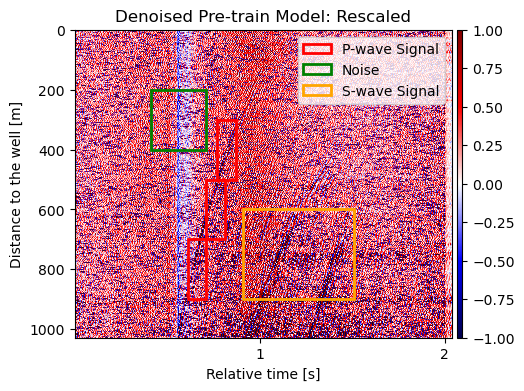

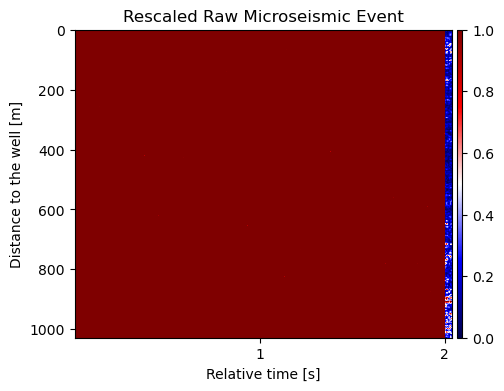

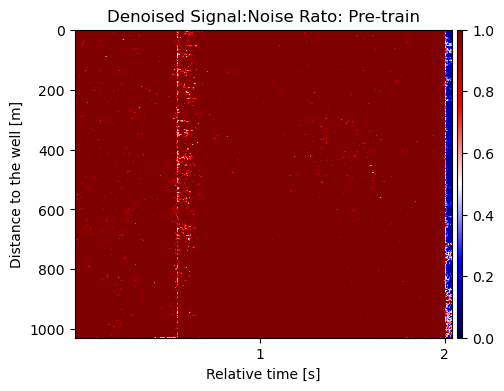

In [19]:
""" Callbacks """
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
noisy_data_raw= np.load(("./Data/SampleData/test_2.npy"))

test_arrays_max = np.abs(noisy_data_raw).max()
rng = np.random.default_rng(42)
mean = 0
std = 1 
num_samples = [1029,4096]
white_noise =np.random.normal(mean, std, size=num_samples)
white_noise_filtered = butter_bandpass_filter(white_noise, 150, 500, 2000,3)
white_noise_scaled = white_noise_filtered/ np.max(np.abs(white_noise_filtered))
white_noise = rng.uniform(low=-1, high=1, size=num_samples)
print(white_noise.shape)
#white_noise = white_noise_scaled * (test_arrays_max - test_arrays_min) + test_arrays_min
white_noise_scaled_uni = rng.uniform(low=-1, high=1, size=num_samples)
#white_noise_filtered = butter_bandpass_filter(white_noise_scaled_uni, 150, 500, 2000,3)
white_noise_scaled = white_noise_filtered/ np.max(np.abs(white_noise_filtered))
white_noise = white_noise_scaled *test_arrays_max * 2.5  #0.45 or 2.5
uni_noise = white_noise_scaled_uni * test_arrays_max * 0.5
noisy_data_noise = white_noise + noisy_data_raw
noisy_data_noise = np.concatenate((noisy_data_noise[:, 600:], noisy_data_raw), axis=1)

fig, ((ax1)) = plt.subplots(1, 1,  figsize=(5, 4), sharex=True, constrained_layout=False, gridspec_kw={'height_ratios': [1]})

im3 = ax1.imshow(noisy_data_raw[:,1500:3540], cmap='seismic', aspect='auto')
ax1.set_ylabel('Distance to the well [m]', fontsize=10)
ax1.set_xlabel('Relative time [s]', fontsize=10)
ax1.set_title('Microseismic Events - 14:10:51.265', fontsize=12)  # Adding title
#ax1.set_xticks([334, 334*2, 334*3, 334*4, 334*5])
#ax1.set_xticks([1000, 2000, 3000, 4000, 5000])
#ax1.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticks([1000, 2000])
ax1.set_xticklabels([1, 2])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='1.4%', pad=.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
cax.xaxis.set_ticks_position("none")
plt.show()
jdas = JDAS()

def calculate_relative_snr(signal_first, signal_all, noise, fulldata):
    # Flatten the signal and noise arrays
    signal_flat = np.abs(signal_first.flatten())
    signal_all_flat = np.abs(signal_all.flatten())
    noise_flat = noise.flatten()

    # Compute the threshold for the top 10% of the signal values
    threshold = np.percentile(signal_flat, 90)
    threshold_all = np.percentile(signal_flat, 80)

    # Extract the top 10% of the signal values
    top_10_percent_signal = signal_flat[signal_flat >= threshold_all]
    top_10_precent_signal_all = signal_all_flat[signal_all_flat >=threshold]

    # Compute the average of the top 10% of the signal values
    reference_signal_level = np.mean(top_10_percent_signal)
    reference_signal_level_all = np.mean(top_10_precent_signal_all)

    # Rescale the signal and noise values
    rescaled_signal = signal_first / reference_signal_level
    rescaled_noise = noise / reference_signal_level
    rescaled_signal_all = signal_all / reference_signal_level
    rescaled_fulldata = fulldata/reference_signal_level

    # Compute signal power (rescaled)
    signal_power = np.mean(rescaled_signal ** 2)
    signal_power_all = np.mean(rescaled_signal_all **2)

    # Compute noise power (rescaled)
    noise_power = np.mean(rescaled_noise ** 2)

    # Calculate the relative SNR
    snr = signal_power / noise_power
    snr_all = signal_power_all /noise_power

    return snr, snr_all, rescaled_fulldata
model_name = "MinMax_flip"
#
logdir = os.path.join("logs", model_name)
if os.path.isdir(logdir):
    shutil.rmtree(logdir)
#    
savefile = "MinMax_flip.h5"
savedir = os.path.join("save", model_name)
if not os.path.isdir(savedir):
    os.makedirs(savedir)

tensorboard_callback = jdas.callback_tensorboard(logdir)
checkpoint_callback = jdas.callback_checkpoint(os.path.join(savedir, savefile))

model = jdas.load_model(os.path.join(savedir, savefile))
model = jdas.load_model()
#post_train = jdas.denoise(noisy_data_noise)

fig, ((ax1)) = plt.subplots(1, 1,  figsize=(5, 4), sharex=True, constrained_layout=False, gridspec_kw={'height_ratios': [1]})

im3 = ax1.imshow(noisy_data_noise[:,1500:3540], cmap='seismic', aspect='auto', clim = [-5,5])
ax1.set_ylabel('Distance to the well [m]', fontsize=10)
ax1.set_xlabel('Relative time [s]', fontsize=10)
ax1.set_title('Noised Added Result', fontsize=12) 
ax1.set_xticks([1000, 2000])
ax1.set_xticklabels([1, 2])
# Adding title
#ax1.set_xticks([334, 334*2, 334*3, 334*4, 334*5])
#ax1.set_xticks([1000, 2000, 3000, 4000, 5000])
#ax1.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5])


divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='1.4%', pad=.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
cax.xaxis.set_ticks_position("none")

plt.show()

x_slice = slice(2300,2500)
y_slice = slice(0,500)
z_slice = slice(3000,3600)
noisy_data_raw_snr = noisy_data_raw[200:400, x_slice] 
signal_data_raw_snr = noisy_data_raw[400:600,  y_slice] 
signal_data_all_raw_snr = noisy_data_raw[600:900, z_slice]
noisy_data_noise_snr = noisy_data_noise[200:400, x_slice] 
signal_data_noise_snr = noisy_data_noise[400:600,  y_slice] 
signal_data_all_noise_snr = noisy_data_noise[600:900, z_slice]
noise_data_uni = post_train[200:400, x_slice] 
signal_data_uni = post_train[0:200,  y_slice]
signal_data_all_uni = post_train[600:900, z_slice] 
# Coordinates for the rectangles
rectangles = [
    (2860, 300, 100, 200),
    (2800, 500, 100, 200),
    (2700, 700, 100, 200)
]

# Extract parts for signal based on rectangles
signal_data_raw_snr = []
signal_data_uni = []

for (x_start, y_start, width, height) in rectangles:
    x_slice = slice(x_start, x_start + width)
    y_slice = slice(y_start, y_start + height)
    signal_data_raw_snr.append(noisy_data_raw[y_slice, x_slice])
    signal_data_uni.append(post_train[y_slice, x_slice])
    
signal_data_raw_snr = np.concatenate(signal_data_raw_snr, axis=None)
signal_data_uni = np.concatenate(signal_data_uni, axis=None)
raw_snr,raw_snr_all, noisy_raw_rescaled = calculate_relative_snr(signal_data_raw_snr,signal_data_all_raw_snr, noisy_data_raw_snr,noisy_data_noise )
white_snr,white_snr_all, noisy_white_rescaled = calculate_relative_snr(signal_data_raw_snr,signal_data_all_raw_snr, noisy_data_noise_snr,noisy_data_raw )
post_train = jdas.denoise(noisy_raw_rescaled)
post_snr,post_snr_all, post_rescaled  = calculate_relative_snr(signal_data_uni, signal_data_all_uni,noise_data_uni, post_train)
print("Raw Relative SNR: (P-wave)", raw_snr)
print("Raw Relative SNR: (S-wave)", raw_snr_all)
print("White Noise Added Relative SNR: (P-wave):", white_snr)
print("White Noise Added Relative SNR: (S-wave)", white_snr_all)
print("Denoised Relative SNR: (P-wave):", post_snr)
print("Denoised Relative SNR: (S-wave)", post_snr_all)

fig, ((ax1)) = plt.subplots(1, 1,  figsize=(5, 4), sharex=True, constrained_layout=False, gridspec_kw={'height_ratios': [1]})

im3 = ax1.imshow(noisy_raw_rescaled[:,1500:3540], cmap='seismic', aspect='auto', clim = [-1,1])
ax1.set_ylabel('Distance to the well [m]', fontsize=10)
ax1.set_xlabel('Relative time [s]', fontsize=10)
ax1.set_title('Noise Data: Rescaled w.r.t First Arrival as 1 ', fontsize=12)  # Adding title
#ax1.set_xticks([334, 334*2, 334*3, 334*4, 334*5])
#ax1.set_xticks([1000, 2000, 3000, 4000, 5000])
#ax1.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticks([1000, 2000])
ax1.set_xticklabels([1, 2])
# Add signal box (red)
rectangles = [
    (2860-2090, 300, 100, 200),
    (2800-2090, 500, 100, 200),
    (2700-2090, 700, 100, 200)
]

for (x, y, width, height) in rectangles:
    rect = Rectangle((x, y), width, height, edgecolor='red', facecolor='none', lw=2)
    ax1.add_patch(rect)

signal_all_rect = Rectangle((z_slice.start-2090, 600), z_slice.stop - z_slice.start, 300, edgecolor='orange', facecolor='none', lw=2)
ax1.add_patch(signal_all_rect)
# Add noise box (green)
noise_rect = Rectangle((x_slice.start-200-2090, 200), x_slice.stop - x_slice.start+200, 200, edgecolor='green', facecolor='none', lw=2)
ax1.add_patch(noise_rect)
signal_legend = Patch(edgecolor='red', facecolor='none', lw=2, label='P-wave Signal')
noise_legend = Patch(edgecolor='green', facecolor='none', lw=2, label='Noise')
signal_all_legend = Patch(edgecolor='orange', facecolor='none', lw=2, label='S-wave Signal')

# Add legend to the plot
ax1.legend(handles=[signal_legend, noise_legend, signal_all_legend], loc='upper right')


divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='1.4%', pad=.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
cax.xaxis.set_ticks_position("none")
plt.show()

fig, ((ax1)) = plt.subplots(1, 1,  figsize=(5, 4), sharex=True, constrained_layout=False, gridspec_kw={'height_ratios': [1]})

im3 = ax1.imshow(post_rescaled[:,1500:3540], cmap='seismic', aspect='auto',clim=[-1,1])
ax1.set_ylabel('Distance to the well [m]', fontsize=10)
ax1.set_xlabel('Relative time [s]', fontsize=10)
ax1.set_title('Denoised Pre-train Model: Rescaled', fontsize=12)  # Adding title
#ax1.set_xticks([334, 334*2, 334*3, 334*4, 334*5])
#ax1.set_xticks([1000, 2000, 3000, 4000, 5000])
#ax1.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticks([1000, 2000])
ax1.set_xticklabels([1, 2])
divider = make_axes_locatable(ax1)
rectangles = [
    (2860-2090, 300, 100, 200),
    (2800-2090, 500, 100, 200),
    (2700-2090, 700, 100, 200)
]

for (x, y, width, height) in rectangles:
    rect = Rectangle((x, y), width, height, edgecolor='red', facecolor='none', lw=2)
    ax1.add_patch(rect)

signal_all_rect = Rectangle((z_slice.start-2090, 600), z_slice.stop - z_slice.start, 300, edgecolor='orange', facecolor='none', lw=2)
ax1.add_patch(signal_all_rect)
# Add noise box (green)
noise_rect = Rectangle((x_slice.start-200-2090, 200), x_slice.stop - x_slice.start+200, 200, edgecolor='green', facecolor='none', lw=2)
ax1.add_patch(noise_rect)
signal_legend = Patch(edgecolor='red', facecolor='none', lw=2, label='P-wave Signal')
noise_legend = Patch(edgecolor='green', facecolor='none', lw=2, label='Noise')
signal_all_legend = Patch(edgecolor='orange', facecolor='none', lw=2, label='S-wave Signal')

# Add legend to the plot
ax1.legend(handles=[signal_legend, noise_legend, signal_all_legend], loc='upper right')
ax1.legend(handles=[signal_legend, noise_legend, signal_all_legend], loc='upper right')

cax = divider.append_axes('right', size='1.4%', pad=.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
cax.xaxis.set_ticks_position("none")

plt.show()

fig, ((ax1)) = plt.subplots(1, 1,  figsize=(5, 4), sharex=True, constrained_layout=False, gridspec_kw={'height_ratios': [1]})

im3 = ax1.imshow(np.abs(noisy_raw_rescaled[:,1500:3540]), cmap='seismic', aspect='auto', clim = [0,1])
ax1.set_ylabel('Distance to the well [m]', fontsize=10)
ax1.set_xlabel('Relative time [s]', fontsize=10)
ax1.set_title('Rescaled Raw Microseismic Event', fontsize=12)  # Adding title
#ax1.set_xticks([334, 334*2, 334*3, 334*4, 334*5])
#ax1.set_xticks([1000, 2000, 3000, 4000, 5000])
#ax1.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticks([1000, 2000])
ax1.set_xticklabels([1, 2])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='1.4%', pad=.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
cax.xaxis.set_ticks_position("none")
plt.show()

fig, ((ax1)) = plt.subplots(1, 1,  figsize=(5, 4), sharex=True, constrained_layout=False, gridspec_kw={'height_ratios': [1]})

im3 = ax1.imshow(np.abs(post_rescaled[:,1500:3540]), cmap='seismic', aspect='auto',clim=[0,1])
ax1.set_ylabel('Distance to the well [m]', fontsize=10)
ax1.set_xlabel('Relative time [s]', fontsize=10)
ax1.set_title('Denoised Signal:Noise Rato: Pre-train', fontsize=12)  # Adding title
#ax1.set_xticks([334, 334*2, 334*3, 334*4, 334*5])
#ax1.set_xticks([1000, 2000, 3000, 4000, 5000])
#ax1.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticks([1000, 2000])
ax1.set_xticklabels([1, 2])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='1.4%', pad=.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
cax.xaxis.set_ticks_position("none")

plt.show()

Because the noise (Random Gaussian Noise) is added manually in the range of 150 Hz to 500Hz, we can adopt a post data filter to see how much signal it can retrieved from noise!

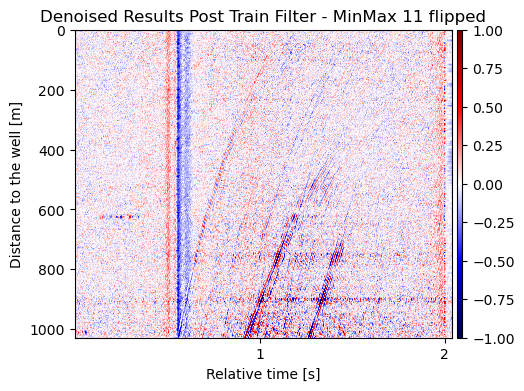

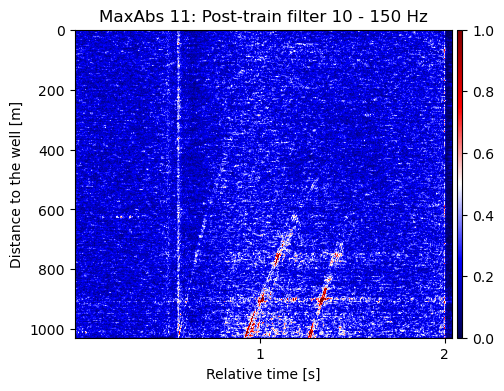

In [20]:


# Apply bandpass filter to your DAS data
filtered_data = butter_bandpass_filter(post_rescaled, 10, 150, 4000, 1)

fig, ((ax1)) = plt.subplots(1, 1,  figsize=(5, 4), sharex=True, constrained_layout=False, gridspec_kw={'height_ratios': [1]})

im3 = ax1.imshow(filtered_data[:,1500:3540], cmap='seismic', aspect='auto',clim=[-1,1])
ax1.set_ylabel('Distance to the well [m]', fontsize=10)
ax1.set_xlabel('Relative time [s]', fontsize=10)
ax1.set_title('Denoised Results Post Train Filter - MinMax 11 flipped', fontsize=12)  # Adding title
#ax1.set_xticks([334, 334*2, 334*3, 334*4, 334*5])
#ax1.set_xticks([1000, 2000, 3000, 4000, 5000])
#ax1.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticks([1000, 2000])
ax1.set_xticklabels([1, 2])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='1.4%', pad=.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
cax.xaxis.set_ticks_position("none")

plt.show()

fig, ((ax1)) = plt.subplots(1, 1,  figsize=(5, 4), sharex=True, constrained_layout=False, gridspec_kw={'height_ratios': [1]})

im3 = ax1.imshow(np.abs(filtered_data[:,1500:3540]), cmap='seismic', aspect='auto',clim=[0,1])
ax1.set_ylabel('Distance to the well [m]', fontsize=10)
ax1.set_xlabel('Relative time [s]', fontsize=10)
ax1.set_title('MaxAbs 11: Post-train filter 10 - 150 Hz', fontsize=12)  # Adding title
#ax1.set_xticks([334, 334*2, 334*3, 334*4, 334*5])
#ax1.set_xticks([1000, 2000, 3000, 4000, 5000])
#ax1.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticks([1000, 2000])
ax1.set_xticklabels([1, 2])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='1.4%', pad=.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
cax.xaxis.set_ticks_position("none")

plt.show()

Single Trace Comparison: With regarding raw data and the denoised data. 

31.96632327616285
Processing 1 / 2
33/33 [==============================] - 5s 147ms/step
Processing 2 / 2
33/33 [==============================] - 4s 133ms/step


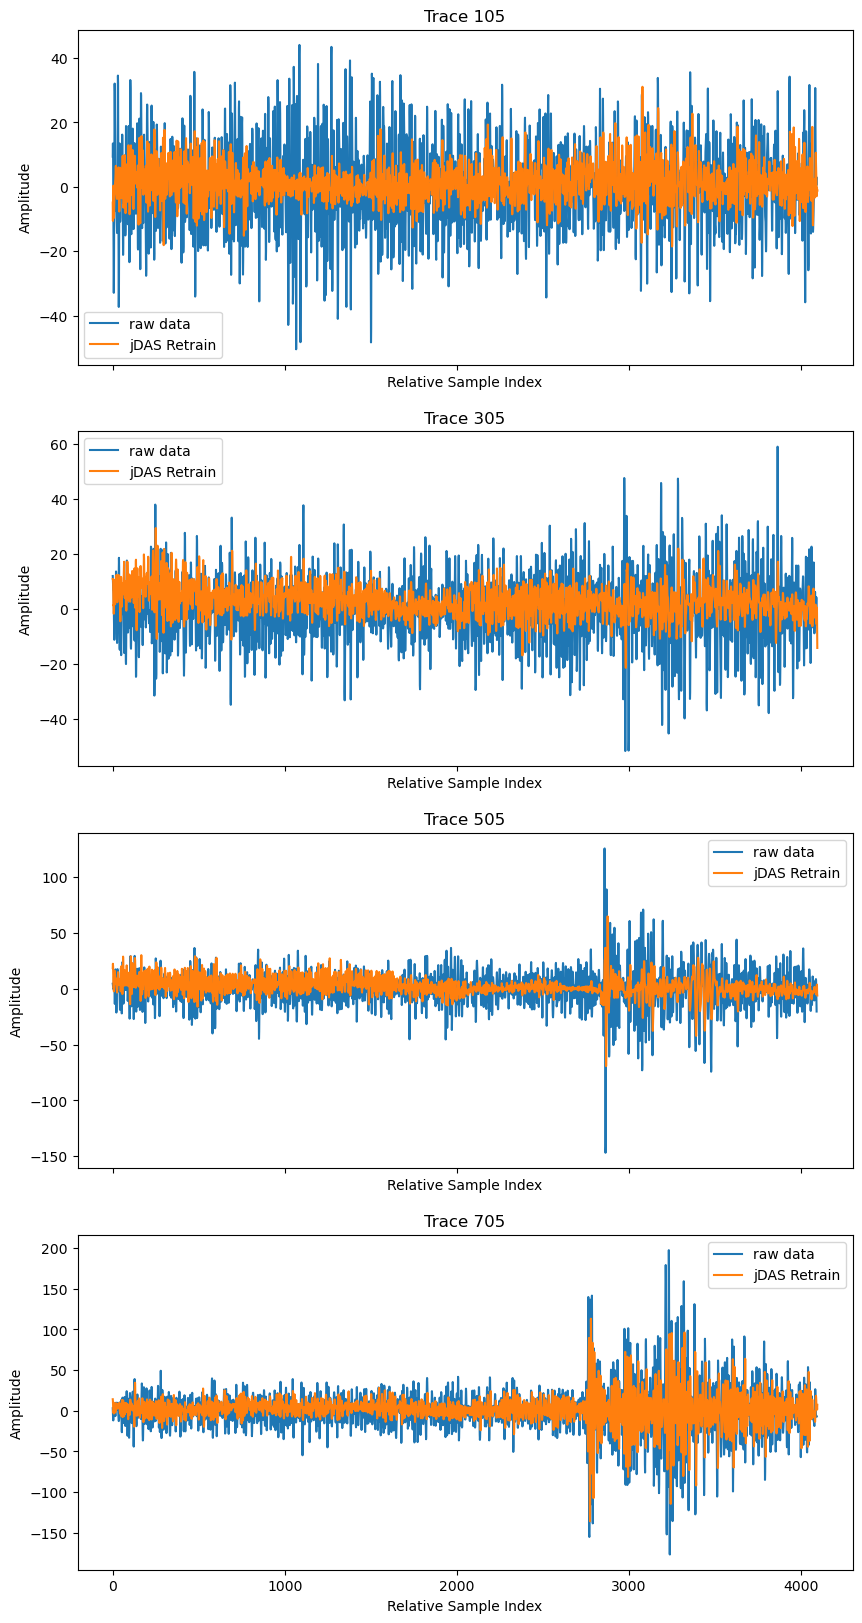

In [48]:

post_train_raw = jdas.denoise(noisy_data_raw)
def plot_traces(start_trace, interval, num_traces, data_raw, data_pre, data_re):
    fig, axs = plt.subplots(num_traces, 1, figsize=(10, 20), sharex=True)
    for i in range(num_traces):
        trace_index = start_trace + i * interval 
        #trace_index = i + 700
        axs[i].plot(data_raw[trace_index,3500:], label='raw data')
        axs[i].plot(data_pre[trace_index,:], label='jDAS Retrain')
        #axs[i].plot(data_re[trace_index, :], label='jDAS retrain')
        #axs[i].plot(data4[trace_index, 0:3000], label='Bandpass 10-100 Hz')
        axs[i].set_title(f'Trace {trace_index}')
        axs[i].set_ylabel('Amplitude')
        axs[i].set_xlabel('Relative Sample Index')
        #axs[i].set_ylim([-20, 20])
        #axs[i].set_xticklabels(np.arange(0, len(data_raw), 200))
        axs[i].legend()
    plt.show()


plot_traces(start_trace=105, interval=200, num_traces=4, data_raw=noisy_data_noise, data_pre=post_train_raw ,data_re=post_rescaled)

Simple STA/LTA Algorithm:
It cannot be run in the .ipynb for some reasons, which you can use Run_script_detectipn.py to see the denoised results.

In [28]:
#STA/LTA
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger
df = 1/2000
data_all = post_train
cft = classic_sta_lta(data_all[770], int(0.2 * df), int(10 * df))
plot_trigger(data_all[770], cft, 1.5, 0.5)

: 

Callbacks for the model:

In [2]:
""" Callbacks """

jdas = JDAS()
model = jdas.load_model()
model_name = "MinMax"

logdir = os.path.join("logs", model_name)
if os.path.isdir(logdir):
    shutil.rmtree(logdir)
    
savefile = "MinMax.h5"
savedir = os.path.join("save", model_name)
if not os.path.isdir(savedir):
    os.makedirs(savedir)

tensorboard_callback = jdas.callback_tensorboard(logdir)
checkpoint_callback = jdas.callback_checkpoint(os.path.join(savedir, savefile))